# Linear regression from ``scratch``

In [75]:
import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet import gluon

## 定义context

In [76]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## 拟合的回归式

$$y = 2 \times X[0] - 3.4 \times X[1] + 4.2$$

## 模拟生成数据

In [84]:
num_input = 2
num_output = 1
num_example = 1000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random.normal(shape=(num_example, num_input))
noise = .0001 * nd.random.normal(shape=(num_example,))
y = real_fn(X) + noise

In [85]:
X[0]


[ 0.78318954  0.8391512 ]
<NDArray 2 @cpu(0)>

In [86]:
y[0]


[ 2.91344619]
<NDArray 1 @cpu(0)>

In [87]:
2 * X[0, 0] - 3.4 * X[0, 1] + 4.2


[ 2.91326475]
<NDArray 1 @cpu(0)>

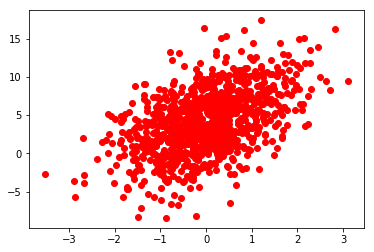

In [88]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0].asnumpy(), y.asnumpy(), color='red')
plt.show()

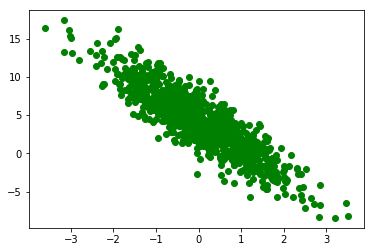

In [89]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy(), color='green')
plt.show()

## Gluon构造迭代器的方法

In [90]:
batch_size = 10
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y), batch_size=batch_size, shuffle=True)
for data, label in train_data:
    print(data, label)
    break


[[-0.0533869   0.67921829]
 [-0.1149158  -1.36402798]
 [ 1.24306011 -0.49131575]
 [-0.09006171 -0.61383039]
 [-0.27758768  1.99984539]
 [ 0.23847078  0.9730252 ]
 [-1.27164257  2.04120636]
 [-1.67629254 -1.321316  ]
 [ 0.58792311 -0.18004932]
 [ 0.67715609  1.10360956]]
<NDArray 10x2 @cpu(0)> 
[ 1.78383589  8.60795593  8.35635757  6.10702896 -3.15464354  1.36865401
 -5.28355694  5.339993    5.98800945  1.80209339]
<NDArray 10 @cpu(0)>


## 手写构造迭代器的方法

In [91]:
import random
batch_size = 10
def data_iter():
    idx = list(range(num_example))
    random.shuffle(idx)
    for i in range(0, num_example, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_example)])
        yield nd.take(X, j), nd.take(y, j)

## 模型参数

In [92]:
W = nd.random.normal(shape=(num_input, num_output))
b = nd.random.normal(shape=num_output)
params = [W, b]
params

[
 [[ 1.12511396]
  [ 1.53862846]]
 <NDArray 2x1 @cpu(0)>, 
 [-0.51917189]
 <NDArray 1 @cpu(0)>]

In [93]:
for param in params:
    param.attach_grad()

## 定义模型

In [94]:
def net(X):
    return nd.dot(X, W) + b

## 损失函数

In [95]:
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape))**2

## 定义优化器

In [96]:
def SGD(params, lr):
    for param in params:
        # in-place operation
        param[:] = param - lr * param.grad

## 训练

In [97]:
epochs = 10
learning_rate = .001
num_batches = num_example / batch_size

for epochs in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, average loss %f." % (epochs, cumulative_loss / num_example))
    

Epoch 0, average loss 11.812016.
Epoch 1, average loss 0.195490.
Epoch 2, average loss 0.003376.
Epoch 3, average loss 0.000061.
Epoch 4, average loss 0.000001.
Epoch 5, average loss 0.000000.
Epoch 6, average loss 0.000000.
Epoch 7, average loss 0.000000.
Epoch 8, average loss 0.000000.
Epoch 9, average loss 0.000000.


In [98]:
params

[
 [[ 2.00000072]
  [-3.40000081]]
 <NDArray 2x1 @cpu(0)>, 
 [ 4.19999886]
 <NDArray 1 @cpu(0)>]

## 可视化

Epoch 0, Batch 99, Moving Avg Loss 4.981258, Average Loss: 10.418923


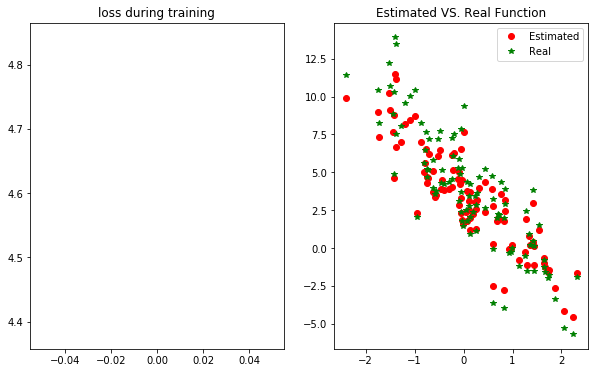

Epoch 1, Batch 199, Moving Avg Loss 1.910348, Average Loss: 0.182221


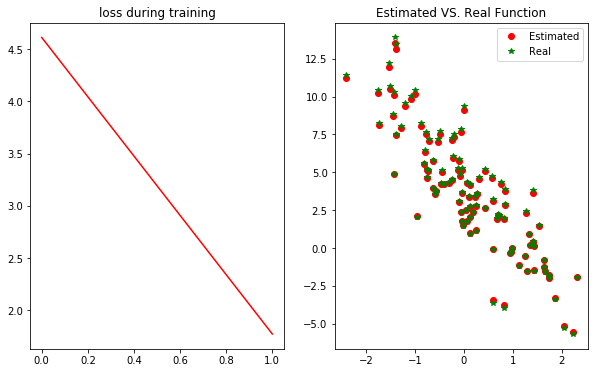

Epoch 2, Batch 299, Moving Avg Loss 0.701054, Average Loss: 0.003560


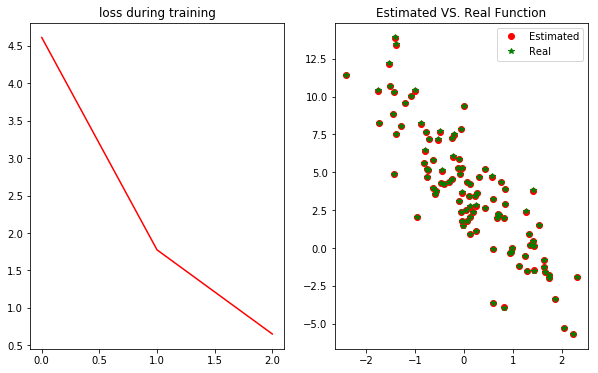

Epoch 3, Batch 399, Moving Avg Loss 0.256646, Average Loss: 0.000076


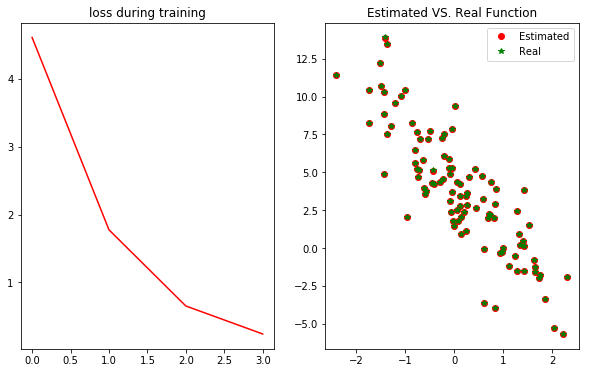

Epoch 4, Batch 499, Moving Avg Loss 0.093941, Average Loss: 0.000002


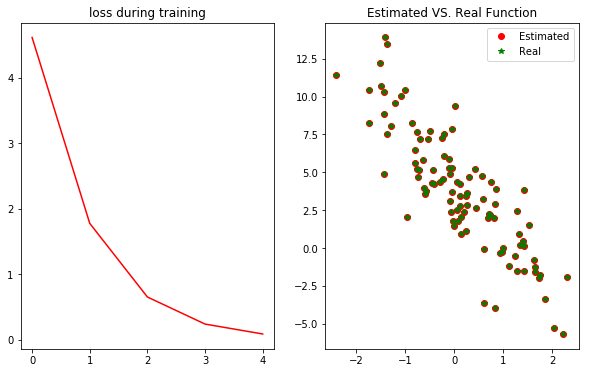

Epoch 5, Batch 599, Moving Avg Loss 0.034386, Average Loss: 0.000000


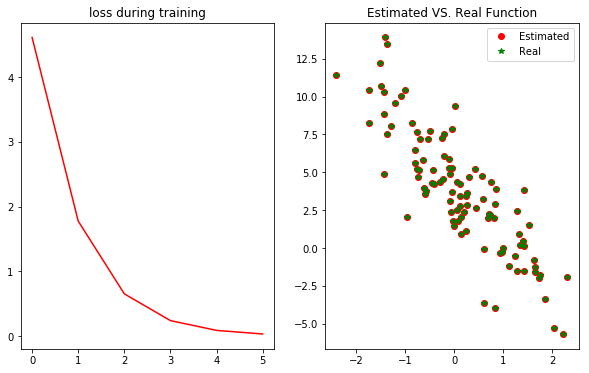

Epoch 6, Batch 699, Moving Avg Loss 0.012586, Average Loss: 0.000000


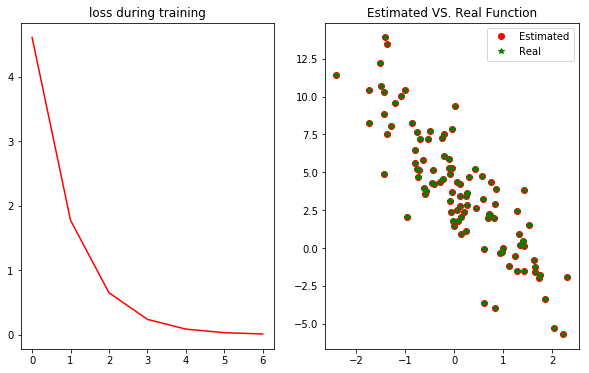

Epoch 7, Batch 799, Moving Avg Loss 0.004607, Average Loss: 0.000000


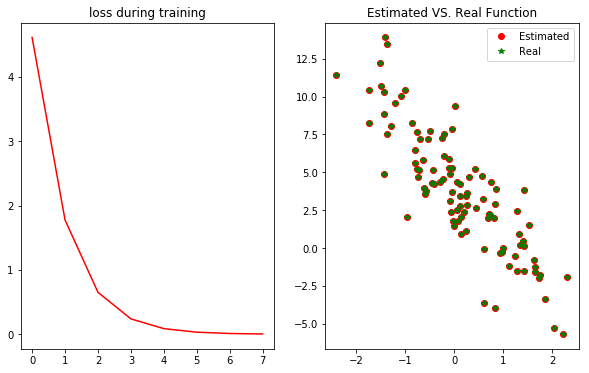

Epoch 8, Batch 899, Moving Avg Loss 0.001686, Average Loss: 0.000000


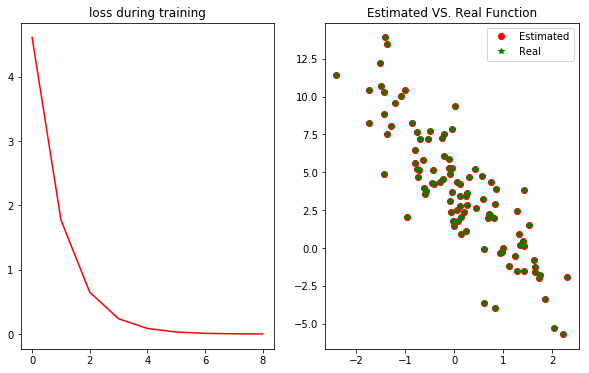

Epoch 9, Batch 999, Moving Avg Loss 0.000617, Average Loss: 0.000000


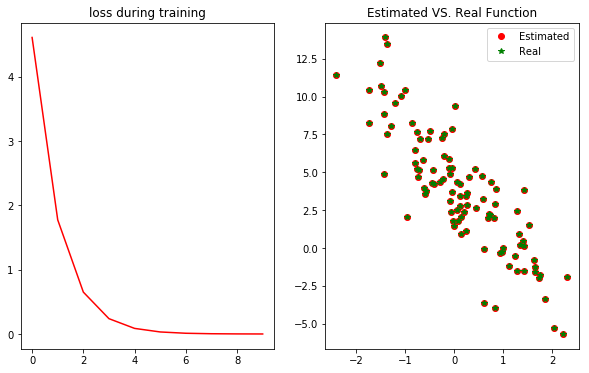

In [99]:
# 重新初始化参数因为它们已经在上方被训练过了
W[:] = nd.random.normal(shape=(num_input, num_output))
b[:] = nd.random.normal(shape=num_output)

def plot(losses, X, sample_size=100):
    idx = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1,2, figsize=(10, 6))
    fg1.set_title("loss during training")
    fg1.plot(idx, losses, 'r')
    fg2.set_title("Estimated VS. Real Function") 
    fg2.plot(X[:sample_size, 1].asnumpy(), net(X[:sample_size, :]).asnumpy(), "or", label="Estimated")
    fg2.plot(X[:sample_size, 1].asnumpy(), real_fn(X[:sample_size, :]).asnumpy(), '*g', label="Real")
    fg2.legend()
    plt.show()
    
losses = []
learning_rate = .001
niter = 0 #记录第多少次batch
moving_loss = 0
smoothing_constant = .01

for epoch in range(10):
    cumulative_loss = 0
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()
        
        # 记录每读取一个batch后，损失的移动平均值的变化
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        # 对moving_loss做偏差修正，以减轻moving_loss被初始化为0在迭代初期对计算加权平均的影响
        est_loss = moving_loss / 1-(1-smoothing_constant)**niter
        if (niter+1)%100 == 0 :
            losses.append(est_loss)
            print("Epoch %s, Batch %s, Moving Avg Loss %f, Average Loss: %f" % 
                (epoch, niter, moving_loss, cumulative_loss / num_example))
            plot(losses, X)